In [408]:
import pandas as pd

prices = pd.read_csv('../data/raw/stock_data.csv')
prices.set_index('Date', inplace=True)

# ticker_A, ticker_B = 'KO', 'PEP' # Coca-Cola and PepsiCo
ticker_A, ticker_B = 'XOM', 'CVX'
# price_window = prices.loc['2015-01-06':'2016-04-04'] # arbitrary approx. 1 year chosen
# price_window = prices[[ticker_A, ticker_B]].loc['2015-01-06':'2016-04-04']
# price_window = prices[[ticker_A, ticker_B]].loc['2015-01-06':'2016-01-20']
# price_window = prices[[ticker_A, ticker_B]].loc['2020-02-20':'2020-06-11']
# 2017-01-03 to 2017-04-28
# 2018-11-01 to 2019-04-30
price_window = prices[[ticker_A, ticker_B]].loc['2017-01-03':'2017-04-28']
print(price_window)
dates = price_window.index

prices_A = price_window[ticker_A] # just price levels
prices_B = price_window[ticker_B]

                  XOM        CVX
Date                            
2017-01-03  61.254543  81.146362
2017-01-04  60.580627  81.125702
2017-01-05  59.677540  80.774529
2017-01-06  59.643833  80.450935
2017-01-09  58.659874  79.762383
...               ...        ...
2017-04-24  55.163242  73.636940
2017-04-25  55.584927  74.193062
2017-04-26  55.360497  73.741188
2017-04-27  55.265289  73.317162
2017-04-28  55.530510  74.172195

[81 rows x 2 columns]


In [409]:
# if linear combination of 2 price levels is stationary, likely good candidates
# so cointegration test
from statsmodels.tsa.stattools import coint
coint_t, p_value, _ = coint(prices_A, prices_B)
print(f'Cointegration test p-value: {p_value}')
# A p-value < 0.05 typically indicates cointegration

Cointegration test p-value: 0.007070022674386997


In [410]:
'''
priceA = alpha + beta * priceB + residuals
alpha is constant offset, beta is hedge ratio, residuals are spread
so spread = priceA - (alpha + beta * priceB)

We want to estimate alpha and beta using linear regression
Then we can compute spread and see if it's stationary
'''

import statsmodels.api as sm
X = sm.add_constant(prices_B) # add column of 1s for intercept
model = sm.OLS(prices_A, X).fit() # ordinary least squares regression
alpha, beta = model.params
print(f'Alpha: {alpha}, Beta: {beta}')
spread = model.resid
# print(spread)


Alpha: 21.301401051882, Beta: 0.45645840179432656


In [411]:
# ADF test to check if spread actually mean-reverting
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(spread)
print(f"p-value: {adf_result[1]}")
# p-value < 0.05 indicates stationarity

p-value: 0.0014076409816424316


In [412]:
# compute z scores
z_scores = (spread - spread.mean()) / spread.std()
print(z_scores)

'''
z_scores = z_scores.values.tolist()
too_big = 0
too_small = 0
fine = 0
for i in z_scores:
    if abs(i) > 2:
        too_big += 1
    if abs(i) < 0.5:
        too_small += 1
    else:
        fine += 1
print(too_big, too_small, fine)
'''

Date
2017-01-03    3.628162
2017-01-04    2.800598
2017-01-05    1.875511
2017-01-06    2.017489
2017-01-09    1.183477
                ...   
2017-04-24    0.310908
2017-04-25    0.519937
2017-04-26    0.497309
2017-04-27    0.619788
2017-04-28    0.464027
Length: 81, dtype: float64


'\nz_scores = z_scores.values.tolist()\ntoo_big = 0\ntoo_small = 0\nfine = 0\nfor i in z_scores:\n    if abs(i) > 2:\n        too_big += 1\n    if abs(i) < 0.5:\n        too_small += 1\n    else:\n        fine += 1\nprint(too_big, too_small, fine)\n'

In [413]:
# everyday, look at today's z score
for date in dates:
    score = z_scores.loc[date]
    if score > 2: # A overpriced relative to B
        print(f"Day {date}: Short A, Long B")
        signal = 1
    elif score < -2: # B overpriced relative to A
        print(f"Day {date}: Long A, Short B")
        signal = -1
    elif abs(score) < 0.5: # spread has reverted to mean
        print(f"Day {date}: Close positions")
        signal = 0
    else:
        print(f"Day {date}: Hold positions")


Day 2017-01-03: Short A, Long B
Day 2017-01-04: Short A, Long B
Day 2017-01-05: Hold positions
Day 2017-01-06: Short A, Long B
Day 2017-01-09: Hold positions
Day 2017-01-10: Hold positions
Day 2017-01-11: Hold positions
Day 2017-01-12: Close positions
Day 2017-01-13: Close positions
Day 2017-01-17: Hold positions
Day 2017-01-18: Hold positions
Day 2017-01-19: Hold positions
Day 2017-01-20: Close positions
Day 2017-01-23: Close positions
Day 2017-01-24: Hold positions
Day 2017-01-25: Hold positions
Day 2017-01-26: Close positions
Day 2017-01-27: Hold positions
Day 2017-01-30: Hold positions
Day 2017-01-31: Close positions
Day 2017-02-01: Close positions
Day 2017-02-02: Close positions
Day 2017-02-03: Hold positions
Day 2017-02-06: Hold positions
Day 2017-02-07: Hold positions
Day 2017-02-08: Hold positions
Day 2017-02-09: Hold positions
Day 2017-02-10: Hold positions
Day 2017-02-13: Hold positions
Day 2017-02-14: Hold positions
Day 2017-02-15: Hold positions
Day 2017-02-16: Hold positio

In [414]:
# executing trades
cash = 100,000
price_A = prices_A.iloc[-1] # for now
price_B = prices_B.iloc[-1] # ""

# long/short in porportion to Beta
# to short A, long B:

quantity_A = cash // (price_A + abs(beta) * price_B)
quantity_B = abs(beta) * quantity_A # else make it 0

print(quantity_A, quantity_B)
# something wrong

[1. 0.] [0.4564584 0.       ]


In [415]:
from collections import defaultdict
from src.portfolio import Portfolio

pf = Portfolio()
shortings = defaultdict(int)

# say we want to short A, long B
pf.cash += price_A * quantity_A
shortings[ticker_A] += quantity_A

pf.buy(ticker_B, price_B, quantity_B)

new_price_A = price_A - 1
new_price_B = price_B + 1

# to close deal:
shortings[ticker_A] -= quantity_A # are we always selling all?
pf.cash -= new_price_A * quantity_A 

pf.sell(ticker_B, new_price_B, quantity_B)

ModuleNotFoundError: No module named 'src'

Data shape: (2516, 22)
Columns: ['Date', 'AAPL', 'AMZN', 'BA', 'BAC', 'CAT', 'CVX', 'DIS', 'GOOGL', 'GS', 'JNJ', 'JPM', 'KO', 'MCD', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'UNH', 'XOM']
Date range: 2015-01-02 to 2024-12-31

=== DATA QUALITY CHECK ===
KO missing values: 0
PEP missing values: 0
KO data type: float64
PEP data type: float64

KO sample values: [30.22262764 30.22262764 30.45212173 30.83223152 31.20517921]
PEP sample values: [69.21911621 68.69875336 68.1783371  70.17193604 71.44726562]


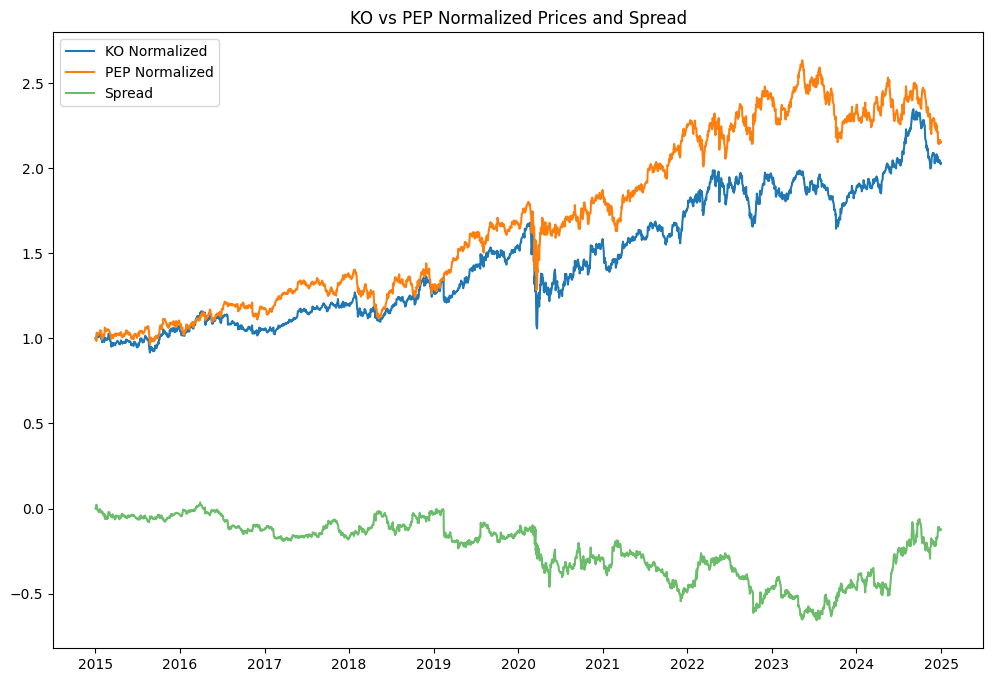

In [ ]:
# ChatGPT code for visualising

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt

# Load and check your data
prices = pd.read_csv('../data/raw/stock_data.csv')
print("Data shape:", prices.shape)
print("Columns:", prices.columns.tolist())
print("Date range:", prices['Date'].min(), "to", prices['Date'].max())

# Set index and check
prices.set_index('Date', inplace=True)
prices.index = pd.to_datetime(prices.index)

# Basic data quality check
print("\n=== DATA QUALITY CHECK ===")
print("KO missing values:", prices['KO'].isnull().sum())
print("PEP missing values:", prices['PEP'].isnull().sum())
print("KO data type:", prices['KO'].dtype)
print("PEP data type:", prices['PEP'].dtype)

# Check if they're actually price data (not returns)
print("\nKO sample values:", prices['KO'].head().values)
print("PEP sample values:", prices['PEP'].head().values)

# Plot to see if they LOOK cointegrated
plt.figure(figsize=(12, 8))

# Normalize for comparison
ko_norm = prices['KO'] / prices['KO'].iloc[0]
pep_norm = prices['PEP'] / prices['PEP'].iloc[0]

plt.plot(ko_norm, label='KO Normalized')
plt.plot(pep_norm, label='PEP Normalized')
plt.plot(ko_norm - pep_norm, label='Spread', alpha=0.7)
plt.legend()
plt.title('KO vs PEP Normalized Prices and Spread')
plt.show()

# If the spread looks mean-reverting visually but test says no,
# there might be structural breaks or other issues

In [ ]:
# deepseek code to find good periods

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt

# Load your data
prices = pd.read_csv('../data/raw/stock_data.csv', index_col='Date', parse_dates=True)

non_overlapping_periods = [
    # 2015-2016 Periods
    ('2015-01-05', '2015-06-30'),   # 6 months
    ('2015-07-01', '2015-12-31'),   # 6 months
    
    # 2016-2017 Periods  
    ('2016-01-04', '2016-06-30'),   # 6 months
    ('2016-07-01', '2016-12-30'),   # 6 months
    ('2017-01-03', '2017-04-28'),   # 4 months
    
    # 2017-2018 Periods
    ('2017-05-01', '2017-10-31'),   # 6 months
    ('2017-11-01', '2018-04-30'),   # 6 months
    
    # 2018-2019 Periods
    ('2018-05-01', '2018-10-31'),   # 6 months
    ('2018-11-01', '2019-04-30'),   # 6 months
    
    # 2019-2020 Periods
    ('2019-05-01', '2019-10-31'),   # 6 months
    ('2019-11-01', '2020-04-30'),   # 6 months (includes COVID crash)
    
    # 2020-2021 Periods
    ('2020-05-01', '2020-10-31'),   # 6 months (recovery)
    ('2020-11-01', '2021-04-30'),   # 6 months
    
    # 2021-2022 Periods
    ('2021-05-01', '2021-10-31'),   # 6 months
    ('2021-11-01', '2022-04-30'),   # 6 months
    
    # 2022-2023 Periods
    ('2022-05-01', '2022-10-31'),   # 6 months
    ('2022-11-01', '2023-04-30'),   # 6 months
    
    # 2023-2024 Periods
    ('2023-05-01', '2023-10-31'),   # 6 months
    ('2023-11-01', '2024-04-30'),   # 6 months
]

# Test all non-overlapping periods
print("Testing non-overlapping periods for KO-PEP cointegration:\n")
print("Period\t\t\t\tDays\tP-value\t\tCointegrated")
print("-" * 65)

working_periods = []
for i, (start, end) in enumerate(non_overlapping_periods):
    try:
        ko_data = prices.loc[start:end]['XOM'].dropna()
        pep_data = prices.loc[start:end]['CVX'].dropna()
        
        common_idx = ko_data.index.intersection(pep_data.index)
        ko_aligned = ko_data.loc[common_idx]
        pep_aligned = pep_data.loc[common_idx]
        
        if len(ko_aligned) < 40:
            continue
            
        coint_t, p_value, _ = coint(ko_aligned, pep_aligned, maxlag=1)
        
        status = "YES" if p_value < 0.05 else "NO"
        print(f"Period {i+1:2d}: {start} to {end}\t{len(ko_aligned)}\t{p_value:.6f}\t{status}")
        
        if p_value < 0.05:
            working_periods.append((start, end, p_value, len(ko_aligned)))
            
    except Exception as e:
        print(f"Error in period {i+1}: {e}")

print(f"\nFound {len(working_periods)} working non-overlapping periods:")
for start, end, p_val, days in working_periods:
    print(f"{start} to {end} (p-value: {p_val:.6f}, {days} days)")

Testing non-overlapping periods for KO-PEP cointegration:

Period				Days	P-value		Cointegrated
-----------------------------------------------------------------
Period  1: 2015-01-05 to 2015-06-30	123	0.667009	NO
Period  2: 2015-07-01 to 2015-12-31	128	0.251069	NO
Period  3: 2016-01-04 to 2016-06-30	125	0.301810	NO
Period  4: 2016-07-01 to 2016-12-30	127	0.339213	NO
Period  5: 2017-01-03 to 2017-04-28	81	0.007070	YES
Period  6: 2017-05-01 to 2017-10-31	129	0.816381	NO
Period  7: 2017-11-01 to 2018-04-30	123	0.803991	NO
Period  8: 2018-05-01 to 2018-10-31	129	0.218460	NO
Period  9: 2018-11-01 to 2019-04-30	122	0.009477	YES
Period 10: 2019-05-01 to 2019-10-31	129	0.126738	NO
Period 11: 2019-11-01 to 2020-04-30	124	0.241417	NO
Period 12: 2020-05-01 to 2020-10-31	128	0.207991	NO
Period 13: 2020-11-01 to 2021-04-30	124	0.617114	NO
Period 14: 2021-05-01 to 2021-10-31	127	0.394602	NO
Period 15: 2021-11-01 to 2022-04-30	125	0.741691	NO
Period 16: 2022-05-01 to 2022-10-31	127	0.791057	NO
Perio